In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read in Data Set

In [2]:
raw_data = pd.read_csv('data/household_power_consumption.txt', sep=';', na_values='?', index_col=0,
                       parse_dates=[[0,1]], infer_datetime_format=True, dayfirst=True)

### Fill missing data with average curve
This method of filling the data will replace each missing value with the average of the last good value and the next good value. If there are multiple missing values, the last good value will be updated as each value is filled in. For example, if the series of data is [0, ?, ?, 4], the filled in set will be [0, 2, 3, 4].  
I think this is a reasonable way to fill in power data since power is continuous and can't change value instantaneously. It might be problematic for the regions where there are many values (multiple days worth) missing, though.

In [3]:
filled_data = raw_data.interpolate()

In [4]:
# Check a few missing value locations to verify the fill worked correctly
print(raw_data.iloc[6838]['Global_active_power'])
print(filled_data.iloc[6839]['Global_active_power'])
print(filled_data.iloc[6840]['Global_active_power'])
print(raw_data.iloc[6841]['Global_active_power'])

0.244
0.24466666666666667
0.24533333333333335
0.24600000000000002


### Add a new column for apparent power and sub-metering remainder
If I remember my power systems courses correctly, the power utility needs to consider apparent power, which is a combination of both active and reactive power. This next bit of code will calculate the apparent power and add it as a new column. This column will be useful if we want to do analysis related to how much power the utility needs to generate.

In [5]:
# Add apparent power column
filled_data['Sub_metering_remainder'] = (filled_data['Global_active_power'] * 1000 / 60 - 
                                         filled_data['Sub_metering_1'] - filled_data['Sub_metering_2'] - 
                                         filled_data['Sub_metering_3'])

filled_data['Global_apparent_power'] = np.sqrt(filled_data['Global_active_power']**2 +
                                              filled_data['Global_reactive_power']**2)

### Aggregate data by hour/day/month/season rather than by minute

In [6]:
hourly_data = filled_data.resample('H').agg({'Global_apparent_power': np.mean})

daily_data = filled_data.resample('D').agg({'Global_apparent_power': np.mean})

weekly_data = filled_data.resample('7D').agg({'Global_apparent_power': np.mean})

monthly_data = filled_data.resample('MS').agg({'Global_apparent_power': np.mean})

seasonal_data = filled_data.resample('QS-JUL').agg({ 'Global_apparent_power': np.mean})

# print(seasonal_data)

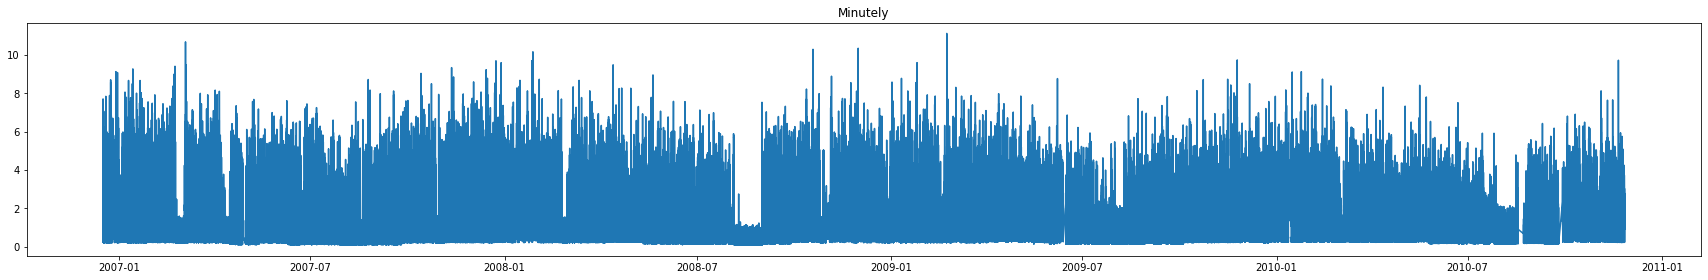

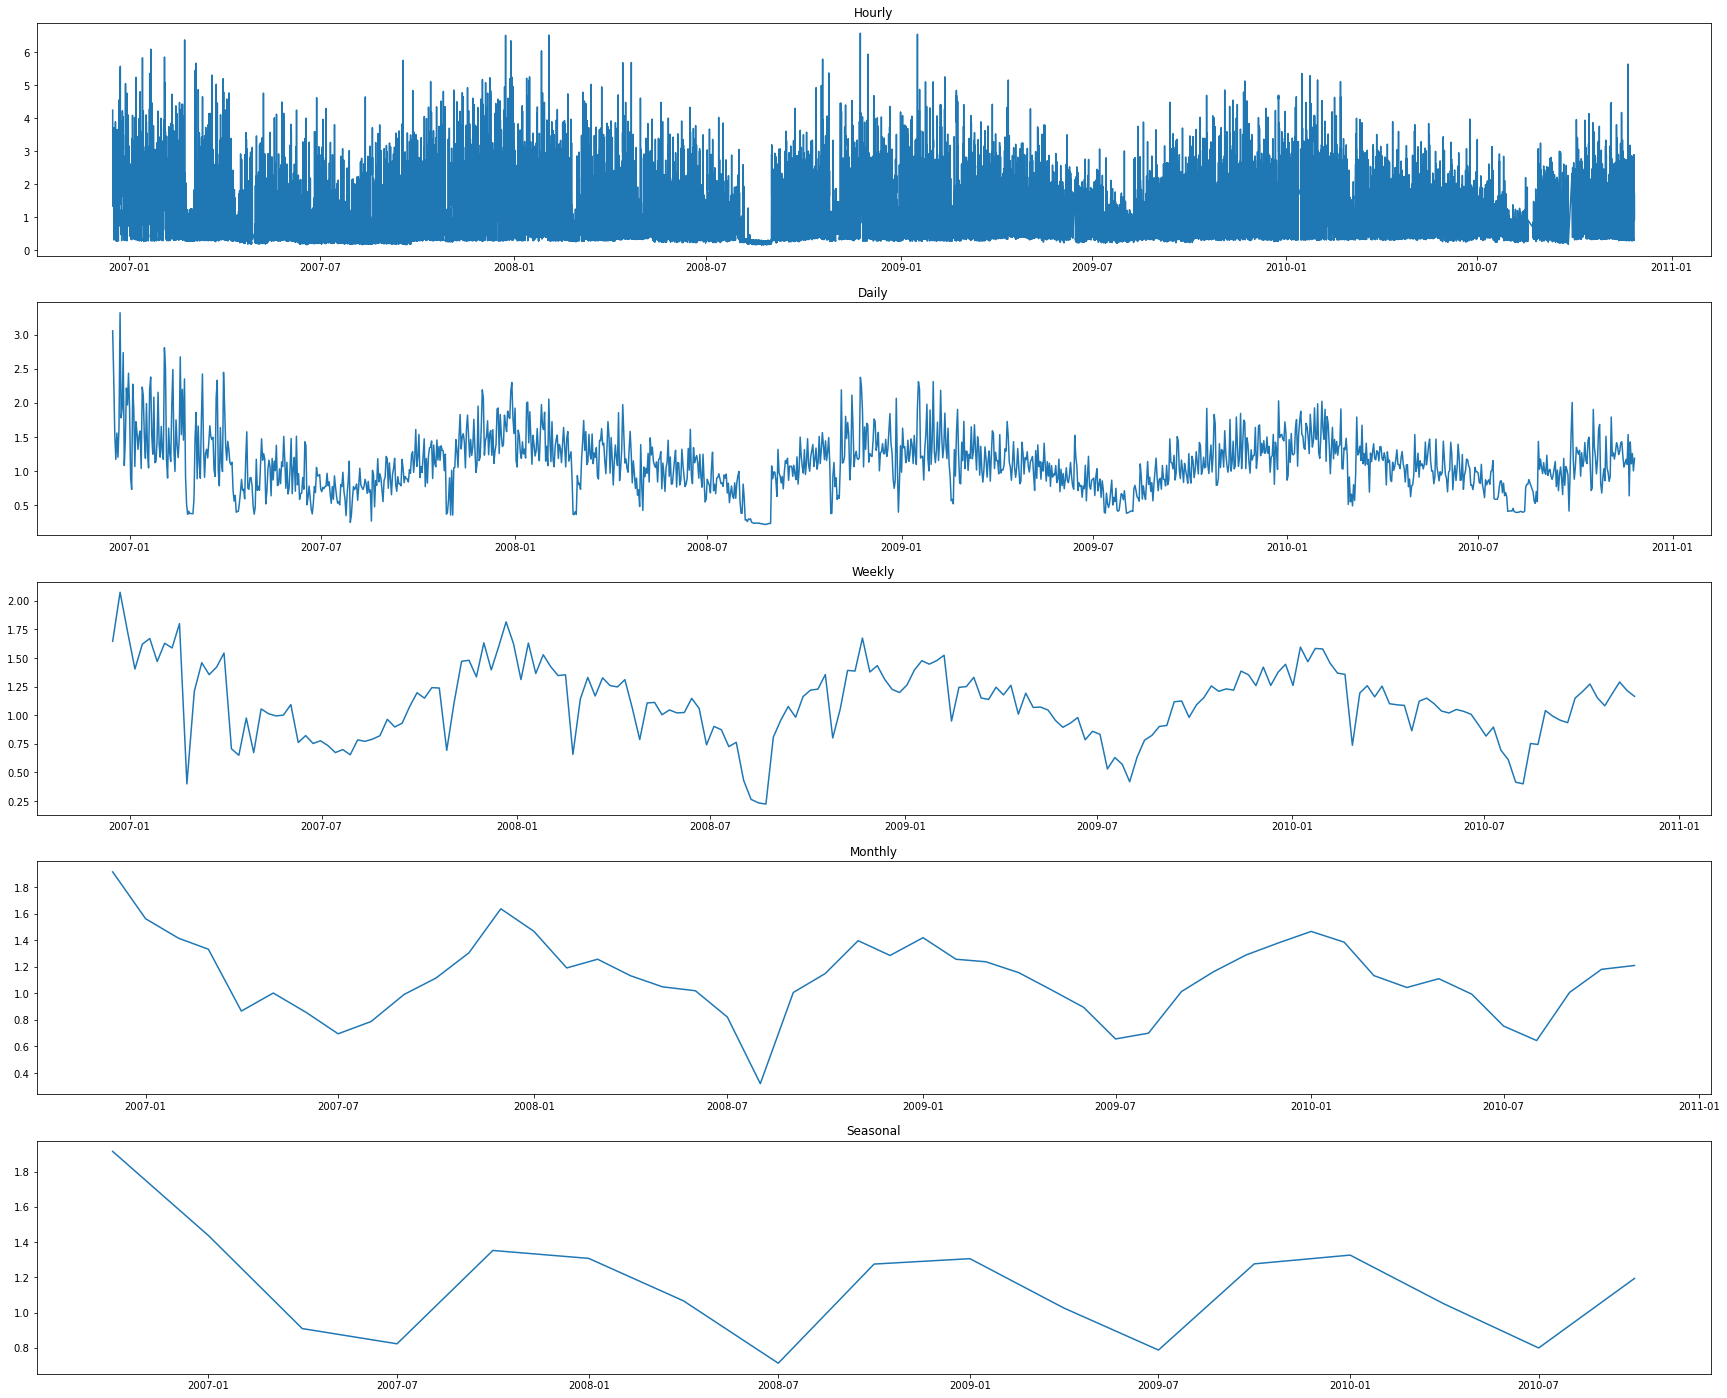

In [7]:
plt.figure(figsize=[30,30])
ax = plt.subplot(6, 1, 1)
plt.plot(filled_data['Global_apparent_power'])
plt.title('Minutely')
plt.figure(figsize=[30,30])
ax = plt.subplot(6, 1, 2)
plt.plot(hourly_data['Global_apparent_power'])
plt.title('Hourly')
ax = plt.subplot(6, 1, 3)
plt.plot(daily_data['Global_apparent_power'])
plt.title('Daily')
ax = plt.subplot(6, 1, 4)
plt.plot(weekly_data['Global_apparent_power'])
plt.title('Weekly')
ax = plt.subplot(6, 1, 5)
plt.plot(monthly_data['Global_apparent_power'])
plt.title('Monthly')
ax = plt.subplot(6, 1, 6)
plt.plot(seasonal_data['Global_apparent_power'])
plt.title('Seasonal')
plt.show()

### Time-series Forecasting - SARIMA 
Most of the code in this section comes from a tutorial found at https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/

In [8]:
import statsmodels.api as sm

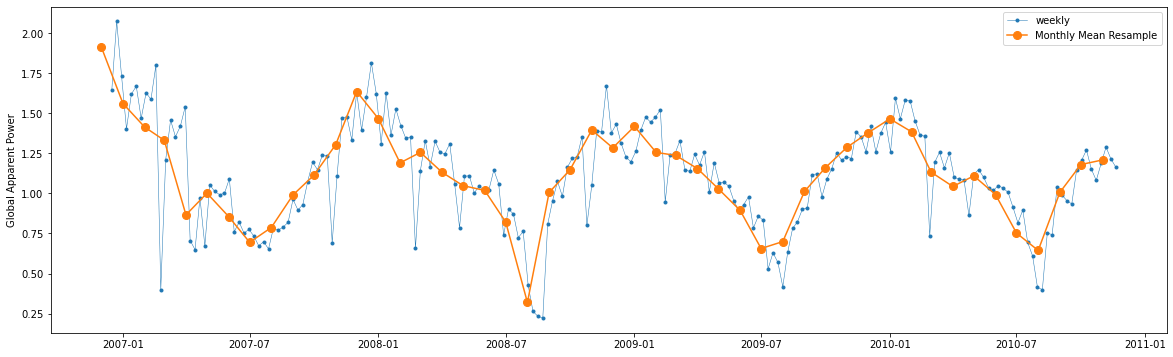

In [9]:
# From https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/

# Set the scale of our data to use. Only really works well on weekly data (or probably larger scales).
# I've tried it on daily, but the parameter optimization takes ages and ran out of RAM on Colab.
scale = 'weekly'
use_differencing = False
if (scale == 'hourly'):
    gap = hourly_data['Global_apparent_power']
    season = 8760
elif (scale == 'daily'):
    gap = daily_data['Global_apparent_power']
    season = 365
elif (scale == 'weekly'):
    gap = weekly_data['Global_apparent_power']
    season = 52

# Plot the data along with a monthly mean to look for general trends.
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(gap, marker='.', linestyle='-', linewidth=0.5, label=scale)
ax.plot(monthly_data['Global_apparent_power'], marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Global Apparent Power')
ax.legend();

In [10]:
# Compute seasonal difference. Not sure if we want to do this or not.
if (use_differencing):
    gap = gap.diff(season)
    gap = gap.drop(gap.index.values[:season], axis=0)#.reset_index(drop=True)

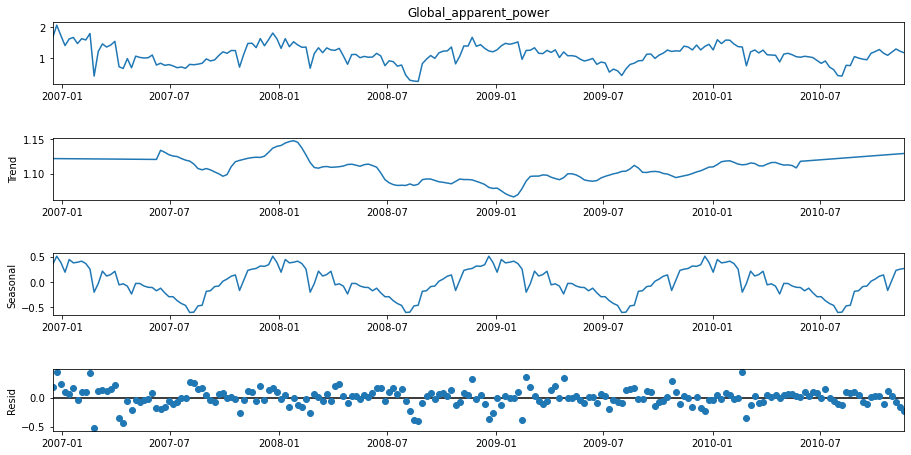

In [11]:
# Graphs to show seasonal_decompose
# The data shows a bit of a trend, but not much. Definite seasonality, most likely on a yearly period.
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()
    
seasonal_decompose(gap)#.loc['2007-01':'2007-02'])

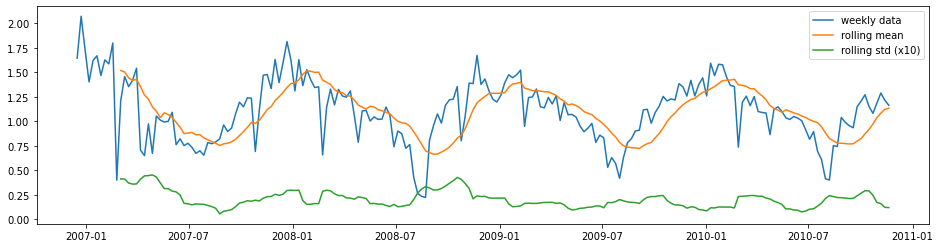

In [12]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(gap,scale+' data')

I think the rolling mean here should be flatter for the data to be stationary. This can be achieved by using the seasonal differencing. But the ADF score says this is stationary enough as is.

In [13]:
# Compute the ADF statistic, which is a measure of how "stationary" the data is.
# The SARIMA algorithm works best on stationary data.
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format
              (k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))
        
ADF_test(gap, scale+' data')

 > Is the weekly data stationary ?
Test statistic = -3.717
P-value = 0.004
Critical values :
	1%: -3.4645146202692527 - The data is  stationary with 99% confidence
	5%: -2.8765564361715534 - The data is  stationary with 95% confidence
	10%: -2.5747745328940375 - The data is  stationary with 90% confidence


#### Separate into Test and Train sets

In [14]:
y_to_train = gap[:'2009'] # dataset to train
y_to_test = gap['2010':] # last year for test  
predict_date = len(gap) - len(gap[:'2019-06-02']) # the number of data points for the test set

#### Generate and Evaluate **Model**

In [15]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2469      0.159      1.553      0.120      -0.065       0.559
ma.L1         -0.6241      0.127     -4.901      0.000      -0.874      -0.375
ar.S.L52       0.2999      0.046      6.509      0.000       0.210       0.390
sigma2         0.0280      0.003     10.707      0.000       0.023       0.033


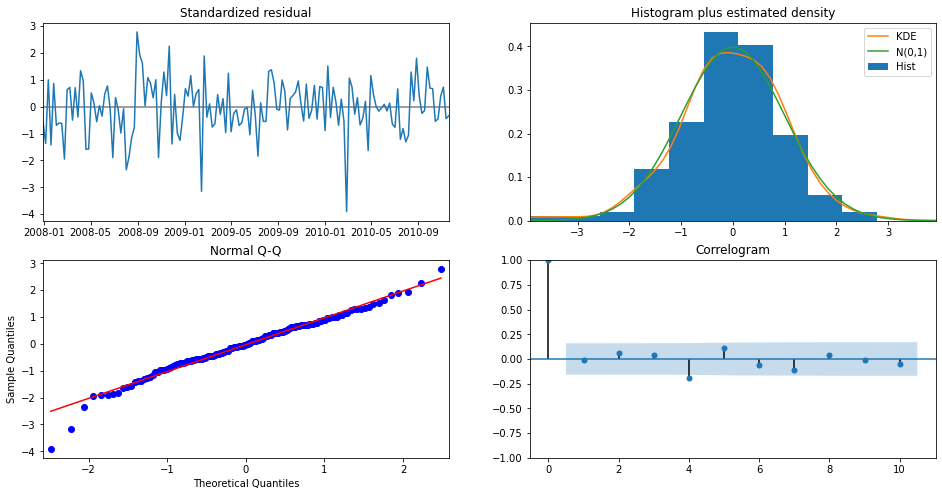

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = False 0.16


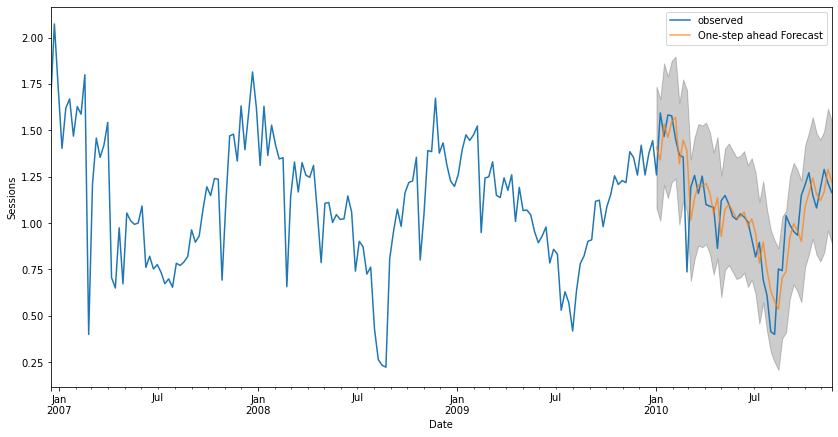

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = True 0.33


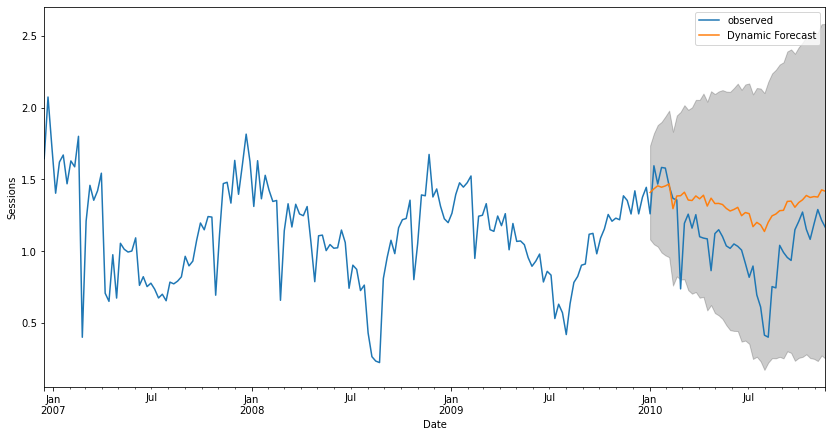

In [16]:
# You have to manually change the parameters here.
model = sarima_eva(gap,(1, 1, 1),(1, 0, 0, 52),season,y_to_test.index[0],y_to_test)

In the above, we can see that the model fits the data fairly well from several bits of evidence.  
* In the top-left chart, we can note that the p-value for most of the coefficients is below 0.05, indicating that they are significant with 95% confidence.
* In the top-right chart, the KDE matches up fairly well with the Normal distribution, indicating that the residuals are normally distributed.
* In the bottom-left chart, the data points mostly fall along the line. I believe this also indicates that the residuals follows a Normal distribution.
* The bottom-right chart shows that the residuals have a very low autocorrelation. Also a good thing, although I'm not entirely sure why. That's just what I've been told.
* In the bottom graphs, we can see that the forecasts match the test data fairly well.

#### Forecast Future Data

In [17]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

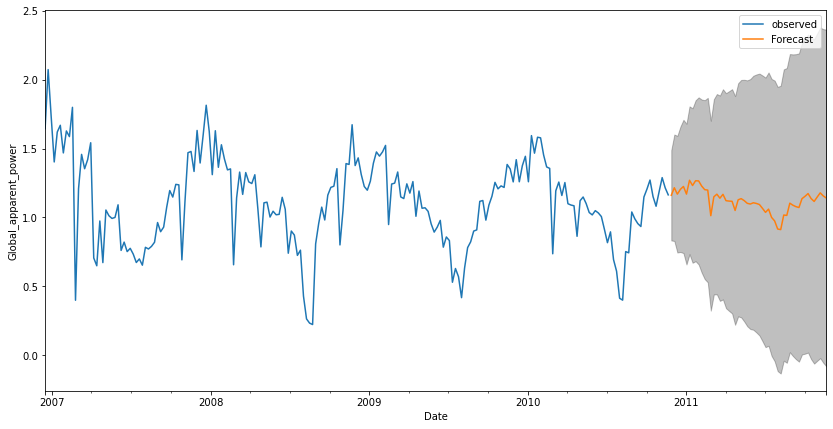

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2010-11-27,1.16112500,0.83315783,1.48909217
1,2010-12-04,1.21575110,0.82937976,1.60212244
2,2010-12-11,1.16917717,0.74555052,1.59280381
3,2010-12-18,1.20452230,0.74946894,1.65957566
4,2010-12-25,1.22512065,0.74131034,1.70893097


In [18]:
final_table = forecast(model,52,gap)
final_table.head()

The forecast looks like it follows the general trend of previous years a bit, but it is much flatter. The confidence interval is also very wide, encompassing basically the full range of the data. Given that, I think this model might be decent at prediction, but I'm not very confident in it.

# Deep Neural Network - Keras 

Using lookback based on https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [19]:
#!pip install keras

First we will break down the date into inputs (year month day etc) vs output (Global_apparent_power)
using dayofyear rather than month and day to reduce input variables and using the hour data to reduce overall amount of data

In [20]:
input_data=pd.DataFrame(columns=['year','day_in_year','hour'])
input_data['year'] = hourly_data.index.year
input_data['day_in_year'] = hourly_data.index.dayofyear
input_data['hour'] = hourly_data.index.hour
output_data=pd.DataFrame(columns=['power'])
output_data['power'] = hourly_data['Global_apparent_power'].to_numpy()
print(input_data)
print(output_data)

       year  day_in_year  hour
0      2006          350    17
1      2006          350    18
2      2006          350    19
3      2006          350    20
4      2006          350    21
...     ...          ...   ...
34584  2010          330    17
34585  2010          330    18
34586  2010          330    19
34587  2010          330    20
34588  2010          330    21

[34589 rows x 3 columns]
           power
0     4.23503904
1     3.63375292
2     3.40185212
3     3.26988339
4     3.05804943
...          ...
34584 1.72828067
34585 1.57568444
34586 1.66128631
34587 1.16686096
34588 0.93466667

[34589 rows x 1 columns]


create an input and output that is offset by 1 hour
ie if the power was
[1,2,3,4,5]
the input would be
[1,2,3,4]
and the expected output would be
[2,3,4,5]

In [21]:

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
trainX, trainY = create_dataset(output_data[:17295].to_numpy(),1)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX, testY = create_dataset(output_data[17295:].to_numpy(),1)
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

create a basic leaning network that looks at the previous 48 hours to try and predict the next hour

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
model = Sequential()
model.add(LSTM(48, input_shape=(1, 1)))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1)

Epoch 1/5
17293/17293 [==============================] - 50s 3ms/step - loss: 0.4415
Epoch 2/5
17293/17293 [==============================] - 59s 3ms/step - loss: 0.4330
Epoch 3/5
17293/17293 [==============================] - 60s 3ms/step - loss: 0.4337
Epoch 4/5
17293/17293 [==============================] - 52s 3ms/step - loss: 0.4337
Epoch 5/5
17293/17293 [==============================] - 52s 3ms/step - loss: 0.4334


get the error for both the training and the test

In [23]:
import math
from sklearn.metrics import mean_squared_error
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.66 RMSE
Test Score: 0.58 RMSE


The training was consistantly higher then the test, which I can't really explain

plot the actual vs the predicted for both the test and the training as well as the rolling average

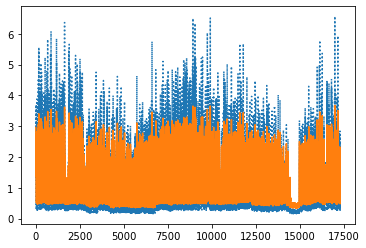

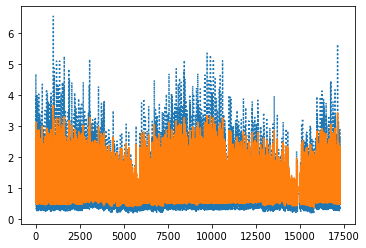

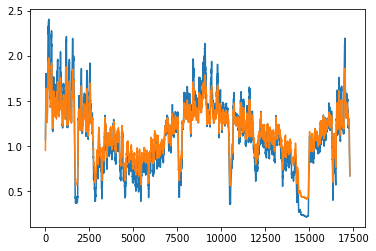

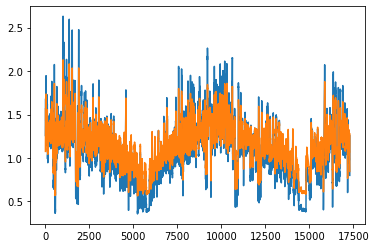

In [24]:
plt.plot(trainY,linestyle = 'dotted')
plt.plot(trainPredict)
plt.show()
plt.plot(testY,linestyle = 'dotted')
plt.plot(testPredict)
plt.show()
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')
x_av = movingaverage(trainY, 72)
trainflat=[i[0] for i in trainPredict]
plt.plot(x_av)
x_av = movingaverage(trainflat, 72)
plt.plot(x_av)
plt.show()
x_av = movingaverage(testY, 24)
testflat=[i[0] for i in testPredict]
plt.plot(x_av)
x_av = movingaverage(testflat, 24)
plt.plot(x_av)
plt.show()

## RandomForestRegressor

Next we'll try a RandomForestRegressor

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
features = input_data.loc[:][['year','day_in_year','hour']]
labels = output_data.loc[:]['power']
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.5)
rf = RandomForestRegressor(n_estimators=800)
rf.fit(train_features, train_labels)
predictions = rf.predict(train_features)
errors = mean_squared_error(predictions,train_labels)
print('train mse:', round(np.mean(errors), 2))
predictions = rf.predict(test_features)
errors = mean_squared_error(predictions,test_labels)
print('test mse:', round(np.mean(errors), 2))

train mse: 0.06
test mse: 0.45


gave extremely good training mse and better test mse

Again plotting the true vs the predicted this seems to handle the jumps better

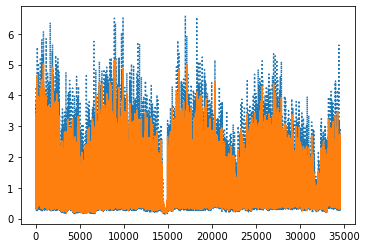

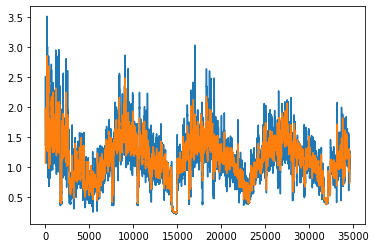

In [26]:
pred=rf.predict(input_data)
plt.plot(output_data,linestyle = 'dotted')
plt.plot(pred)
plt.show()
flat=[i[0] for i in output_data.to_numpy()]
x_av = movingaverage(flat, 24)
plt.plot(x_av)
x_av = movingaverage(pred, 24)
plt.plot(x_av)
plt.show()

## Predicting with temperature data

Read in tempurature data and merge with the main array

In [27]:
temp_2006 = pd.read_csv('data/temp_2006.csv', sep=',') 
temp_2007 = pd.read_csv('data/temp_2007.csv', sep=',') 
temp_2008 = pd.read_csv('data/temp_2008.csv', sep=',') 
temp_2009 = pd.read_csv('data/temp_2009.csv', sep=',') 
temp_2010 = pd.read_csv('data/temp_2010.csv', sep=',') 
temp_data = pd.concat([temp_2006, temp_2007, temp_2008, temp_2009, temp_2010])
temp_datetime_data = pd.to_datetime( temp_data[['year','month','day']])
temps = pd.concat([temp_datetime_data, temp_data['temp']], axis=1)
temps.columns = ['Date_Time','temp']

In [28]:
merged_daily = pd.merge(daily_data, temps, on="Date_Time")
print(merged_daily.shape)
merged_daily.head()

(1442, 3)


,Date_Time,Global_apparent_power,temp
0,2006-12-16,3.05618716,40.80000000
1,2006-12-17,2.36560220,37.70000000
2,2006-12-18,1.54306864,38.30000000
3,2006-12-19,1.17068159,35.70000000
4,2006-12-20,1.55678499,36.40000000


Here we can see that the temperature data from all of 2006 to 2010 in Paris, France has been merged onto the daily electrical data. It has been merged in such a way to only take the subset of the temperature data that matches to the existing dates on the electrical data

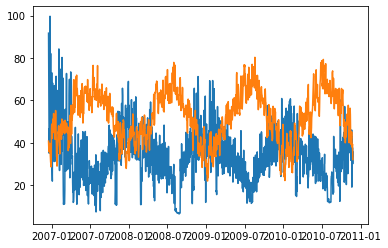

Correlation: -0.5321238799133127


In [29]:
power_temp_corr = merged_daily['Global_apparent_power'].corr(merged_daily['temp'])
plt.plot(merged_daily['Date_Time'], merged_daily['Global_apparent_power']*30)
plt.plot(merged_daily['Date_Time'], merged_daily['temp'])
plt.show()
print("Correlation: " + str(power_temp_corr))

Here we can see that the temperature data is inversely correlated to power usage. As the weather gets very cold, people use more electricity; and as the weather gets nice, people use less electricity.

In [30]:
Expanding on this idea, it is possible to develop a timeseries regession analysis to predict power usage based on weather predictions. For predicting timeseries, it is usually valuable to introduce delayed terms for leveraging trends over time. 

SyntaxError: invalid syntax (<ipython-input-30-33651db556f0>, line 1)

In [ ]:
data_to_regress = pd.concat([merged_daily["Date_Time"], merged_daily["Global_apparent_power"], merged_daily["temp"]], axis=1)
data_to_regress.loc[:,'Yesterday_Power'] = data_to_regress.loc[:,"Global_apparent_power"].shift()
data_to_regress.loc[:,'Yesterday-1_Power'] = data_to_regress.loc[:,"Global_apparent_power"].shift(1)
data_to_regress.loc[:,'Yesterday-2_Power'] = data_to_regress.loc[:,"Global_apparent_power"].shift(2)
data_to_regress.loc[:,'Yesterday-3_Power'] = data_to_regress.loc[:,"Global_apparent_power"].shift(3)
data_to_regress.loc[:,'Last_Week_Power'] = data_to_regress.loc[:,"Global_apparent_power"].shift(7)

data_to_regress.loc[:,'Yesterday_Temp'] = data_to_regress.loc[:,"temp"].shift()
data_to_regress.loc[:,'Yesterday-1_Temp'] = data_to_regress.loc[:,"temp"].shift(1)
data_to_regress.loc[:,'Yesterday-2_Temp'] = data_to_regress.loc[:,"temp"].shift(2)
data_to_regress.loc[:,'Yesterday-3_Temp'] = data_to_regress.loc[:,"temp"].shift(3)
data_to_regress.loc[:,'Last_Week_Temp'] = data_to_regress.loc[:,"temp"].shift(7)

# dropping NAs
data_to_regress = data_to_regress.dropna()
data_to_regress.head()

For testing and training, we can test on the years 2006 to 2009 and test on the year 2010

In [ ]:

mask1 = data_to_regress["Date_Time"] < np.datetime64('2010-01-01')
mask2 = data_to_regress["Date_Time"] >= np.datetime64('2010-01-01')

X_train = data_to_regress[mask1].drop(['Global_apparent_power'], axis = 1).drop(['Date_Time'], axis = 1)
y_train = data_to_regress[mask1]['Global_apparent_power']

X_test = data_to_regress[mask2].drop(['Global_apparent_power'], axis = 1).drop(['Date_Time'], axis = 1)
y_test = data_to_regress[mask2]['Global_apparent_power']

In [ ]:
# code from: https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import sklearn.metrics as metrics
# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits=4)
    
 cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [ ]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))


In [ ]:
from sklearn.model_selection import GridSearchCV
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(1,15)]
}
tscv = TimeSeriesSplit(n_splits=4)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [ ]:
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

By tuning the hyperparameters in the Random Forest Regressor through a grid search algorithm we achieved a slightly better regession accuracy compared to using any of the default sklearn models.

In [ ]:
imp = best_model.feature_importances_
features = X_train.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()